In [ ]:
# EDA

In [39]:
import warnings
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

warnings.filterwarnings("ignore")

#import sklearn
#sklearn.show_versions()
#sklearn.__version__
set_config(display='diagram')

In [40]:
data = pd.read_csv('data/train.csv', index_col=0)

In [4]:
#data.describe()

In [5]:
#data.head()

In [6]:
#somedays = data[(data['date_time'] > '2010-12-1') & (data['date_time'] < '2010-12-20')]
#somedays['sensor_5'].plot(figsize=(15,10))
#plt.show()

In [7]:
#profile = ProfileReport(data)
#profile.to_widgets()
#profile.to_file("data_profile.html")a


In [8]:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
import sklearn

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [41]:
# 5150	0.005636	f25 f52
# 5149	0.004500	f77^2
# 5148	0.003276	f12 f81
# 5147	0.002574	f9 f81
# 5146	0.002218	f3 f46
# 5145	0.002078	f41^2
# 5144	0.001962	f31 f81
# 5143	0.001911	f58 f81
# 5142	0.001853	f41 f58
# 5141	0.001827	f31 f74
# 5140	0.001808	f3 f13
# 5139	0.001772	f13 f52
# 5138	0.001729	f66 f96

def GenerateFeatures(data):

    data.loc[:, 'f25xf52'] = data['f25'] * data['f52']
    data.loc[:, 'f77squared'] = data['f77'] * data['f77']
    data.loc[:, 'f12xf81'] = data['f12'] * data['f81']
    data.loc[:, 'f9xf82'] = data['f9'] * data['f82']
    data.loc[:, 'f3xf46'] = data['f3'] * data['f46']
    data.loc[:, 'f41squared'] = data['f41'] * data['f41']
    data.loc[:, 'f31xf81'] = data['f31'] * data['f81']
    data.loc[:, 'f58xf81'] = data['f58'] * data['f81']
    data.loc[:, 'ff1xf58'] = data['f41'] * data['f58']
    data.loc[:, 'f31xf74'] = data['f31'] * data['f74']
    data.loc[:, 'f3xf13'] = data['f3'] * data['f13']
    data.loc[:, 'f13xf52'] = data['f13'] * data['f52']
    data.loc[:, 'f66xf96'] = data['f66'] * data['f96']
  
    return data

In [42]:
# prepare the data
y = data.pop('loss')
X = GenerateFeatures(data)

In [43]:
#from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
import lightgbm as lgb
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

ct = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), X.columns),
        #('poly_feat_gen', PolynomialFeatures(), X.columns),
    ]
)

#pipeline  = make_pipeline(ct, lgb.LGBMRegressor(n_estimators=460, max_depth=31, learning_rate=0.39, num_leaves=2, metric="rmse", random_state=42))
xgbparams = {'n_estimators': 4805,
    'max_leaves': 166,
    'min_child_weight': 12.264484523041242,
    'learning_rate': 0.007267417374185082,
    'subsample': 0.8277110573761649,
    'colsample_bylevel': 0.5809666800564879,
    'colsample_bytree': 0.6613326502938923,
    'reg_alpha': 0.004798296127133117,
    'reg_lambda': 21.94499581629921,
    }

# ct commented out from 1st param
pipeline  = make_pipeline(xgb.XGBRegressor(eval_metric="rmse", random_state=42, **xgbparams)) #**xgbparams

In [44]:
pipeline.fit(X_train, y_train)
print("Trained pipeline")

Trained pipeline


In [48]:
feature_imp = pd.DataFrame(sorted(zip(pipeline["xgbregressor"].feature_importances_,feature_names)), columns=['Value','Feature'])
feature_imp[feature_imp['Value'] > 0.001500]

,Value,Feature
0,0.007467,f71
1,0.007479,f9
2,0.007481,f39
3,0.007544,f32
4,0.007553,f41
...,...,...
108,0.011551,f0 f10
109,0.012076,f80
110,0.012685,f24
111,0.012934,f0 f1


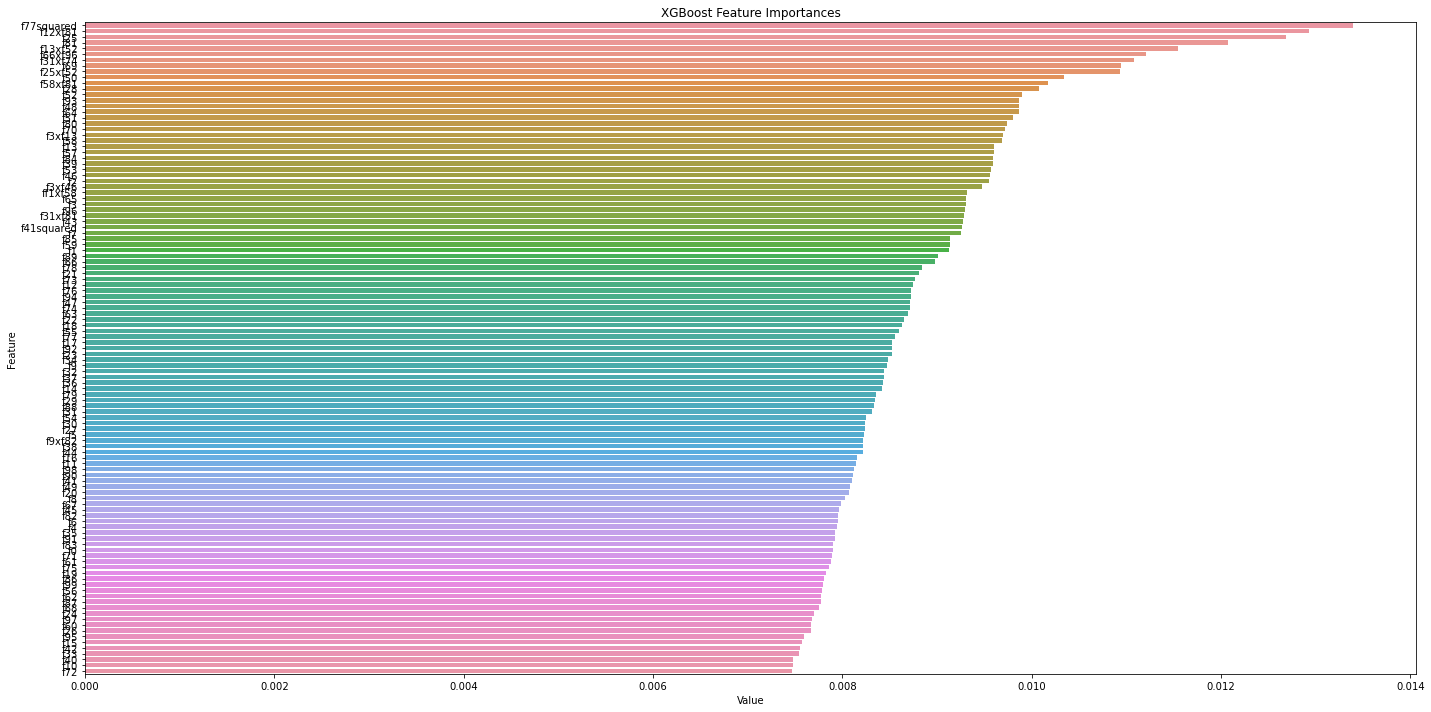

In [50]:
# Get and plot feature importances for XGBoost

#feature_names = pipeline['columntransformer'].named_transformers_['poly_feat_gen'].get_feature_names(X.columns)
feature_names = X.columns

feature_imp = pd.DataFrame(sorted(zip(pipeline["xgbregressor"].feature_importances_,feature_names)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=False)[feature_imp['Value'] > 0.005]

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [20]:
# Get and plot feature importances for LGBM

#lgb.plot_importance(pipeline['lgbmregressor'], max_num_features=30)
feature_names = pipeline['columntransformer'].named_transformers_['poly_feat_gen'].get_feature_names(X.columns)
# feature_names = get_feature_names(pipeline['columntransformer'])))

feature_imp = pd.DataFrame(sorted(zip(pipeline["xgbregressor"].feature_importances_,feature_names)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=False)[feature_imp['Value'] > 2]

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

TypeError: zip() takes no keyword arguments

In [ ]:
important_features = feature_imp['Feature'].str.replace('scaler__', '')
important_features.count()

32

In [52]:
#get_feature_names(pipeline['columntransformer'])
#pipeline['columntransformer'].named_transformers_['poly_feat_gen'].get_feature_names(X.columns)

In [ ]:
# Boxplots
#sns.set(rc={'figure.figsize':(15,10)})
#sns.boxplot(data=data[numerical_columns])
#ct.named_transformers_['poly'].get_feature_names()

In [ ]:
from sklearn.metrics import mean_squared_error
import math

preds = pipeline.predict(X_test) #[numerical_columns]
error = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", error)

preds = pipeline.predict(X_train) #[numerical_columns]
error = mean_squared_error(y_train, preds, squared=False)
print("RMSE:", error)

RMSE: 7.8685223675208595
RMSE: 7.84262664507458


# Hyperparameter tuning

In [ ]:
import optuna
from sklearn import model_selection

def objective(trial):
    params = { #lgbmregressor__
        'n_estimators': trial.suggest_int("n_estimators", 100, 500, step = 20),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 1, step = 0.01),
        'max_depth': trial.suggest_int("max_depth", 1, 50, step = 5),
        "num_leaves": trial.suggest_int("num_leaves", 2, 50, step = 20),
    }

    pipeline  = make_pipeline(ct, lgb.LGBMRegressor(**params, metric="rmse", random_state=42))
    #pipeline.fit(X_train, y_train)
    #preds = pipeline.predict(X_test) #[numerical_columns]
    #error = mean_squared_error(y_test, preds, squared=False)
    score = model_selection.cross_val_score(pipeline, X, y, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -score.mean()
    print("RMSE:", rmse)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)




[I 2021-08-06 23:12:25,305] A new study created in memory with name: no-name-b3b131fc-2e50-4c63-ba99-39fe0d8a0eef
[I 2021-08-06 23:17:05,755] Trial 0 finished with value: 8.195338958696178 and parameters: {'n_estimators': 120, 'learning_rate': 0.67, 'max_depth': 46, 'num_leaves': 22}. Best is trial 0 with value: 8.195338958696178.


RMSE: 8.195338958696178


[I 2021-08-06 23:24:22,666] Trial 1 finished with value: 7.949332523402974 and parameters: {'n_estimators': 280, 'learning_rate': 0.22, 'max_depth': 31, 'num_leaves': 22}. Best is trial 1 with value: 7.949332523402974.


RMSE: 7.949332523402974


[I 2021-08-06 23:33:45,774] Trial 2 finished with value: 8.518984978746357 and parameters: {'n_estimators': 280, 'learning_rate': 0.52, 'max_depth': 36, 'num_leaves': 42}. Best is trial 1 with value: 7.949332523402974.


RMSE: 8.518984978746357


[I 2021-08-06 23:48:07,706] Trial 3 finished with value: 8.769568188533423 and parameters: {'n_estimators': 460, 'learning_rate': 0.68, 'max_depth': 41, 'num_leaves': 22}. Best is trial 1 with value: 7.949332523402974.


RMSE: 8.769568188533423


[I 2021-08-06 23:53:51,239] Trial 4 finished with value: 7.883191291654936 and parameters: {'n_estimators': 200, 'learning_rate': 0.31, 'max_depth': 36, 'num_leaves': 2}. Best is trial 4 with value: 7.883191291654936.


RMSE: 7.883191291654936


[I 2021-08-06 23:58:50,446] Trial 5 finished with value: 7.8965937700146425 and parameters: {'n_estimators': 180, 'learning_rate': 0.14, 'max_depth': 1, 'num_leaves': 42}. Best is trial 4 with value: 7.883191291654936.


RMSE: 7.8965937700146425


[I 2021-08-07 00:03:50,744] Trial 6 finished with value: 8.488863495735215 and parameters: {'n_estimators': 140, 'learning_rate': 0.89, 'max_depth': 46, 'num_leaves': 22}. Best is trial 4 with value: 7.883191291654936.


RMSE: 8.488863495735215


In [ ]:
important_features

NameError: name 'important_features' is not defined

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study)

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study)

# Randomized Search

In [ ]:
# Do some hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_dist = {  'lgbmregressor__n_estimators': [100, 150, 200, 250, 300],
                'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
                'lgbmregressor__max_depth': [15, 20, 25, 30],
                #'lgbmregressor__num_leaves': 32,
                #'lgbmregressor__feature_fraction': 0.8,
                #'lgbmregressor__subsample': 0.2
                }

search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, n_iter=10)
search.fit(X_train, y_train)
print(search.best_params_)
print("search done for cm")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [ ]:
pipeline = search

# make submission predictions
#pred_tuned = search.predict(X_test) 

# Score holdout file for submission

In [51]:
test_data = pd.read_csv('data/test.csv', index_col=0)
test_data = GenerateFeatures(test_data)

In [ ]:
# make submission predictions

holdout_pred = pipeline.predict(test_data)

In [ ]:
test_data['loss'] = holdout_pred
submission = test_data['loss']
submission.to_csv('data/holdout_predictions.csv')
#data_to_save.reset_index()
#data_to_save.to_csv('data/holdout_predictions.csv', index=False)

In [ ]:
test_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,
250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,1.11394,...,0.446389,-422.332,-1.44630,1.69075,1.059300,-3.010570,1.94664,0.529470,1.386950,8.78767
250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,1.09695,...,0.377179,10352.200,21.06270,1.84351,0.251895,4.440570,1.90309,0.248534,0.863881,11.79390
250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,1.15222,...,0.990140,3224.020,-2.25287,1.55100,-0.559157,17.838600,1.83385,0.931796,2.336870,9.05400
250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,1.20157,...,1.396880,9689.760,14.77150,1.41390,0.329272,0.802437,2.23251,0.893348,1.359470,4.84833
250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,1.16807,...,0.862502,2693.350,44.18050,1.58020,-0.191021,26.253000,2.68238,0.361923,1.532800,3.70660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0.751053,77,0.666725,-1.106280,21433.3000,16.58120,122.77900,-0.319314,-82.222900,1.13916,...,1.540530,123.551,13.98240,2.34641,-0.438368,-2.587330,-0.62910,0.358354,1.434990,8.55460
399996,0.734669,41,0.611225,0.740177,294.1850,10.72900,25.03340,0.644556,-13.998000,1.11345,...,0.457699,7051.200,8.85935,1.48816,1.481120,0.307554,2.26251,0.563482,1.872810,12.54960
399997,0.417307,142,-0.357854,-0.836640,1215.2500,10.62460,221.60400,0.875104,-41.531500,1.40427,...,0.391639,10879.100,13.31930,2.11974,0.524081,22.268500,2.40363,0.288236,2.323660,12.33840


In [ ]:
#pipeline_cm.get_params()

# Random things to try/add

In [ ]:
# Random bits to add

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
sns.pairplot(data, hue="target variable")

In [ ]:
# Convert Religion variable to Category
data["Religion (code)"] = data["Religion (code)"].astype("category")

# One hot encode Religion
data = pd.get_dummies(data,prefix=['Religion'], drop_first=True)
data.head()

In [ ]:
import seaborn as sns

sns.displot(data = data, x = "Activity on Company Forums", kind="kde", hue = "EmployeeTargetedOverPastYear", fill=True)